In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2021-09-29 17:53:38.611546: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-29 17:53:38.611680: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Read train and test csv files
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
# to have an overlook of data
train_df.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# replacing nan values with 0
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

### Converting columns with string values to integers

In [5]:
def convert_str_to_num(df, column, saved_dict):
    if saved_dict is not None:
        print('using passed entry dict')
        entry_dict = saved_dict
    else:
        print('creating a new entry dict')
        entry_dict = {}
        unique_entries = list(df[column].unique())
        for idx, value in enumerate(unique_entries):
            entry_dict[value if isinstance(value, str) else str(value)] = idx+1
        
    for i in range(len(df)):
        if df[column][i] in entry_dict:
            df[column][i] = entry_dict[df[column][i]]
        else:
            df[column][i] = 0
        
    # for value in entry_dict:
    #  df[column] = df[column].replace(value, entry_dict[value])
    return df, entry_dict

In [6]:
train_df, sex_dict = convert_str_to_num(train_df.copy(), 'Sex', saved_dict=None)
train_df, cabin_dict = convert_str_to_num(train_df.copy(), 'Cabin', saved_dict=None)
train_df, emb_dict = convert_str_to_num(train_df.copy(), 'Embarked', saved_dict=None)

test_df, _ = convert_str_to_num(test_df.copy(), 'Sex', saved_dict=sex_dict)
test_df, _ = convert_str_to_num(test_df.copy(), 'Cabin', saved_dict=cabin_dict)
test_df, _ = convert_str_to_num(test_df.copy(), 'Embarked', saved_dict=emb_dict)

creating a new entry dict


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


creating a new entry dict


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


creating a new entry dict
using passed entry dict
using passed entry dict
using passed entry dict


### Min Max Normalization

In [7]:
def normalize_column_min_max(df, column, minimum=None, maximum=None):
    if minimum is None or maximum is None:
        print("creating new min max ")
        minimum = df[column].min()
        maximum = df[column].max()
    else:
        print("using passed values")
    
    df[column] = (df[column]-minimum)/(maximum-minimum)
    return df, minimum, maximum

In [8]:
train_df, p_min, p_max = normalize_column_min_max(df=train_df.copy(), column='Pclass')
train_df, a_min, a_max = normalize_column_min_max(df=train_df.copy(), column='Age')
train_df, c_min, c_max = normalize_column_min_max(df=train_df.copy(), column='Cabin')
train_df, e_min, e_max = normalize_column_min_max(df=train_df.copy(), column='Embarked')
train_df, s_min, s_max = normalize_column_min_max(df=train_df.copy(), column='SibSp')
train_df, pc_min, pc_max = normalize_column_min_max(df=train_df.copy(), column='Parch')

test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Pclass', minimum=p_min, maximum=p_max)
test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Age', minimum=a_min, maximum=a_max)
test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Cabin', minimum=c_min, maximum=c_max)
test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Embarked', minimum=e_min, maximum=e_max)
test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='SibSp', minimum=s_min, maximum=s_max)
test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Parch', minimum=pc_min, maximum=pc_max)

creating new min max 
creating new min max 
creating new min max 
creating new min max 
creating new min max 
creating new min max 
using passed values
using passed values
using passed values
using passed values
using passed values
using passed values


### Create train dataset and labels

In [9]:
input_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Cabin', 'Embarked']
train_input = []
train_labels = []

for _, row in train_df.iterrows():
    input_ = []
    train_labels.append([row['Survived']])
    for column in input_columns:
        input_.append(row[column])
    input_ = np.array(input_)
    # input_ = input_.reshape(input_.size, 1)
    train_input.append(input_)

In [10]:
train_input_shuffled, train_labels_shuffled = shuffle(train_input, train_labels)

train_input_shuffled = np.array(train_input_shuffled)
train_labels_shuffled = np.array(train_labels_shuffled)

### Define a simple DNN architecture

In [11]:
model = Sequential()
model.add(layers.Dense(8, input_shape=(None, 7), activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2021-09-29 17:53:46.516620: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-29 17:53:46.519580: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-29 17:53:46.519622: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-29 17:53:46.519649: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3d6469183fef): /proc/driver/nvidia/version does not exist
2021-09-29 17:53:46.520616: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 8)           64        
_________________________________________________________________
dropout (Dropout)            (None, None, 8)           0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 64)          576       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           65        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


### Train

In [14]:
history = model.fit(train_input_shuffled, train_labels_shuffled, validation_split=0.1, epochs=10, batch_size=8, validation_batch_size=1)

2021-09-29 17:53:47.252056: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-29 17:53:47.265582: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/10
101/101 [==============================] - 1s 8ms/step - loss: 0.6936 - accuracy: 0.5791 - val_loss: 0.6003 - val_accuracy: 0.7889
Epoch 2/10
101/101 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6636 - val_loss: 0.5566 - val_accuracy: 0.7889
Epoch 3/10
101/101 [==============================] - 0s 3ms/step - loss: 0.5953 - accuracy: 0.7095 - val_loss: 0.5358 - val_accuracy: 0.7556
Epoch 4/10
101/101 [==============================] - 0s 3ms/step - loss: 0.5889 - accuracy: 0.7121 - val_loss: 0.4977 - val_accuracy: 0.7444
Epoch 5/10
101/101 [==============================] - 0s 3ms/step - loss: 0.5486 - accuracy: 0.7357 - val_loss: 0.4784 - val_accuracy: 0.8000
Epoch 6/10
101/101 [==============================] - 0s 3ms/step - loss: 0.5547 - accuracy: 0.7458 - val_loss: 0.4807 - val_accuracy: 0.8111
Epoch 7/10
101/101 [==============================] - 0s 3ms/step - loss: 0.5458 - accuracy: 0.7477 - val_loss: 0.4616 - val_accuracy: 0.8111
Epoch 

### Train and validation charts

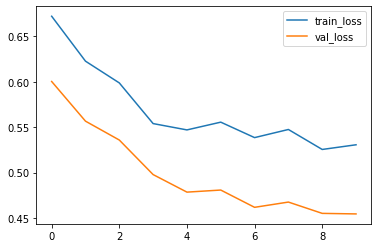

In [15]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

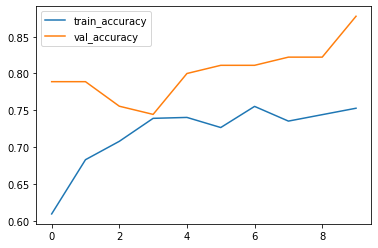

In [16]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

### Predict

In [17]:
result_dict = {'PassengerId': [], 'Survived': []}

for _, row in test_df.iterrows():
    input_ = []
    for column in input_columns:
        input_.append(row[column])
    input_ = np.array(input_)
    # input_ = input_.reshape(input_.size, 1)
    prediction = model.predict(np.array([input_]))
    survived = 0
    if prediction > 0.5:
        survived = 1
    result_dict['PassengerId'].append(row['PassengerId'])
    result_dict['Survived'].append(survived)

In [18]:
result_df = pd.DataFrame(result_dict)

In [19]:
result_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [20]:
# Dump into a csv file
result_df.to_csv('submission.csv', index=False)